# Определение опытных игроков Dota 2 (руководство по решению)

В игре Dota 2 участвуют две стороны: команды сил Света (The Radiant) и сил Тьмы (The Dire). Каждая команда состоит из 5 игроков — персонажей со своими уникальными способностями. Перед началом матча каждый игрок выбирает себе одного героя из 116 возможных. Цель игры — разрушить трон, находящийся на базе противника.

Повышая игровые навыки, игроки повышают свой рейтинг и получают медали опыта. Эксперты по игре Dota 2 утверждают, что легко могут отличить матч новичка от игры опытного игрока.

**Задача — построить алгоритм, который сможет определять опытность игрока по статистике из одного матча.**

In [1]:
csv_data_path = "csv_data"
json_data_path = "json_data"
save_path = "sber_data"

In [2]:
from google.colab import drive
drive.mount('/gdrive')

ModuleNotFoundError: No module named 'google'

## Таблицы с данными

Рассмотрим упрощённый набор данных в виде таблиц `skill_train.csv` и `skill_test.csv`, с которыми удобно оперировать и подавать в алгоритмы машинного обучения.

In [2]:
%pylab inline
import pandas
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [171]:
df_train_or = pandas.read_csv(csv_data_path+'/dota2_skill_train.csv', index_col='id')
df_test_or = pandas.read_csv(csv_data_path+'/dota2_skill_test.csv', index_col='id')

In [19]:
df_train_or = pandas.read_csv(save_path+'/pre_process_csv_json/test_1552737730.csv', index_col='id')
df_test_or = pandas.read_csv(save_path+'/pre_process_csv_json/train_1552737351.csv', index_col='id')

In [158]:

df_train.columns

Index(['skilled', 'duration', 'pre_game_duration', 'first_blood_time',
       'hero_id', 'hero_pick_order', 'party_players', 'kills', 'deaths',
       'assists', 'denies', 'net_worth', 'gold', 'gold_spent', 'last_hits',
       'gold_per_min', 'xp_per_min', 'hero_damage', 'tower_damage',
       'hero_healing', 'scaled_hero_damage', 'scaled_tower_damage',
       'scaled_hero_healing', 'stuns', 'team_fight_participation',
       'observer_wards_placed', 'sentry_wards_placed', 'creeps_stacked',
       'camps_stacked', 'rune_pickups', 'roshan_kills',
       'nearby_creep_death_count', 'radiant_tower_status', 'dire_tower_status',
       'fight_score', 'farm_score', 'support_score', 'push_score',
       'avg_kills_x16', 'avg_deaths_x16', 'avg_assists_x16', 'avg_gpm_x16',
       'avg_xpm_x16', 'best_kills_x16', 'best_assists_x16', 'best_gpm_x16',
       'best_xpm_x16', 'win_streak', 'best_win_streak',
       'upgrade_behavior Point Target', 'upgrade_behavior No Target',
       'upgrade_behavio

In [3]:
df_train = pandas.read_csv(save_path+'/pre_process_csv_json/train_all_9_1.csv', index_col='id')
df_test = pandas.read_csv(save_path+'/pre_process_csv_json/test_all_9_1.csv', index_col='id')

In [ ]:
# x_in["hero_attack_type"] = [df_heroes["attack_type"][i] for i in x_in["hero_id"]]
#     x_in["hero_attack_range"] = [df_heroes["attack_range"][i] for i in x_in["hero_id"]]
#     x_in["hero_base_attack_max"] = [df_heroes["base_attack_max"][i] for i in x_in["hero_id"]]
#     x_in["hero_agi_gain"] = [df_heroes["agi_gain"][i] for i in x_in["hero_id"]]
    
#     x_in["hero_Carry"] = [df_heroes["hero_Carry"][i] for i in x_in["hero_id"]]
#     x_in["hero_Support"] = [df_heroes["hero_Support"][i] for i in x_in["hero_id"]]
#     x_in["hero_Escape"] = [df_heroes["hero_Escape"][i] for i in x_in["hero_id"]]
#     x_in["hero_Nuker"] = [df_heroes["hero_Nuker"][i] for i in x_in["hero_id"]]
#     x_in["hero_Initiator"] = [df_heroes["hero_Initiator"][i] for i in x_in["hero_id"]]
#     x_in["hero_Disabler"] = [df_heroes["hero_Disabler"][i] for i in x_in["hero_id"]]
#     x_in["hero_Jungler"] = [df_heroes["hero_Jungler"][i] for i in x_in["hero_id"]]
#     x_in["hero_Durable"] = [df_heroes["hero_Durable"][i] for i in x_in["hero_id"]]

In [177]:
df_train["winner_team"] = df_train_or["winner_team"]
df_train["player_team"] = df_train_or["player_team"]

df_test["winner_team"] = df_test_or["winner_team"]
df_test["player_team"] = df_test_or["player_team"]

df_train["hero_Support"] = df_train_or["hero_Support"]

df_test["hero_Support"] = df_test_or["hero_Support"]


KeyError: 'hero_Support'

### Значение полей таблиц с данными

Целевая переменная:
- `skilled`: 1 — опытный игрок, 0 — новичок; эту колонку необходимо предсказывать для тестовой выборки

Информация про матч:
- `player_team`: команда, за которую играл игрок (`radiant` или `dire`)
- `winner_team`: победившая команда
- `hero_id`: идентификатор героя, за которого играл целевой игрок (расшифровку см. в таблице `heroes.csv`)
- `duration`: длительность игры в секундах
- `first_blood_time`: время события "первая кровь"
- `first_blood_claimed`: сделал ли целевой игрок "первую кровь"
- `party_players`: сколько игроков было в "пати" вместе с целевым

Показатели целевого игрока в матче:
- `kills`, `deaths`, `assists`, `denies`, `last_hits` — основные игровые показатели (число убийств вражеских героев, число смертей, и др.)
- `stuns`: нанесенные "оглушения" (в секундах)
- `level`: уровень, которого достиг герой к концу игры
- `net_worth`: общая стоимость всего инвентаря героя
- `gold`: число золота на момент игры
- `gold_spent`: сумма потраченного золота за всю игру
- `gold_per_min`: скорость зарабатывания золота
- `xp_per_min`: скорость получения опыта
- `hero_damage`: суммарный урон по вражеским героям
- `tower_damage`: сумарный урон по вражеским башням
- `hero_healing`: суммарное восстановленное здоровье союзных героев 
- `team_fight_participation`: участие в драках
- `observer_wards_placed`, `sentry_wards_placed`: количество установленных на карту "вардов" (предметы, дающие обзор)
- `rune_pickups`: количество собранных рун
- `radiant_tower_status`, `dire_tower_status`: состояние башен команд на конец игры (см. [расшифровку](https://wiki.teamfortress.com/wiki/WebAPI/GetMatchDetails#Tower_Status))
- `radiant_barracks_status`, `dire_barracks_status`: состояние бараков команд на конец игры (см. [расшифровку](https://wiki.teamfortress.com/wiki/WebAPI/GetMatchDetails#Barracks_Status))

Показатели по последним матчам игрока:
- `avg_kills_x16`, `avg_deaths_x16`, `avg_assists_x16`, `avg_gpm_x16`, `avg_xpm_x16`: средние значения показателей за последние 16 игр
- `best_kills_x16`, `best_assists_x16`, `best_gpm_x16`, `best_xpm_x16`: максимальные значения показателей за последние 16 игр
- `win_streak`, `best_win_streak`: число подряд выигранных матчей до текущего, максимальное число подряд выигранных матчей

## Расширенный набор данных

В дополнение к таблицам имеются расширенные наборы данных: `skill_train.jsonlines`, `skill_test.jsonlines` — это текстовые файлы, в каждой строчке записан объект в формате [JSON](https://ru.wikipedia.org/wiki/JSON). В объектах есть все поля из таблиц, но кроме этого есть дополнительные поля, список приведен ниже.

In [122]:
def json_fir_gen_1(record12, x_in):
#     x_in = x_in_1
    
    for j in range(5):
        x_in.loc[record12["id"], 'rad_team_h'+str(j)] = int(record12['radiant_heroes'][j])
    for j in range(5):
        x_in.loc[record12["id"], 'dire_team_h'+str(j)] = int(record12['dire_heroes'][j])
    
#     x_in.loc[record12["id"], "final_items"] = str(record12["final_items"])
    #x_in.loc[record12["id"], "ability_upgrades"] = str(record12["ability_upgrades"])
    return x_in

In [214]:
def json_fir_gen_2(record12, x_in):
#     x_in = x_in_1

    x_in.loc[record12["id"], "farm_score"] = record12["farm_score"]
    x_in.loc[record12["id"], "push_score"] = record12["push_score"]
    x_in.loc[record12["id"], "support_score"] = record12["support_score"]
    #x_in.loc[record12["id"], "ability_upgrades"] = str(record12["ability_upgrades"])
    return x_in

In [241]:
def json_fir_gen_3(record12, x_in):
#     x_in = x_in_1

    x_in.loc[record12["id"], "creeps_stacked"] = record12["creeps_stacked"]
    x_in.loc[record12["id"], "camps_stacked"] = record12["camps_stacked"]
    x_in.loc[record12["id"], "nearby_creep_death_count"] = record12["nearby_creep_death_count"]
    x_in.loc[record12["id"], "pre_game_duration"] = record12["pre_game_duration"]
    x_in.loc[record12["id"], "hero_pick_order"] = record12["hero_pick_order"]
    x_in.loc[record12["id"], "final_items"] = str(record12["final_items"])
    #x_in.loc[record12["id"], "ability_upgrades"] = str(record12["ability_upgrades"])
    return x_in

In [242]:
import json
import tqdm

In [243]:
a = [54456, 55]
str(a)

'[54456, 55]'

In [201]:
with open(json_data_path+'/dota2_skill_train.jsonlines') as fin:
#     print(fin.readlines())
    for line in fin:
        record1 = json.loads(line)
        # обработка record
#         df_train = json_fir_gen_1(record1, df_train)
#         print(record1)
        break

In [244]:
with open(json_data_path+'/dota2_skill_train.jsonlines') as fin:
#     print(fin.readlines())
    for line in fin:
        record1 = json.loads(line)
        # обработка record
        df_train = json_fir_gen_3(record1, df_train)
#         print(record1)
#         break
import time
import os

current_timestamp = int(time.time())
submission_path = save_path+'/pre_process_csv_json/train_{}.csv'.format(current_timestamp)
# submission_path = 'submissions/{}_{}.csv'.format(current_timestamp, str(clf_to_test.get_param('max_depth')) + '_' + str(clf_to_test.get_param('iterations'))+ '_' + str(clf_to_test.get_param('learning_rate') ) )

if not os.path.exists(save_path+'/pre_process_csv_json'):
    os.makedirs(save_path+'/pre_process_csv_json')

print(submission_path)
df_train.to_csv(submission_path, index=True)


with open(json_data_path+'/dota2_skill_test.jsonlines') as fin:
#     print(fin.readlines())
    for line in fin:
        record1 = json.loads(line)
        # обработка record
        df_test = json_fir_gen_3(record1, df_test)
#         print(record1)
#         break
    
current_timestamp = int(time.time())
submission_path = save_path+'/pre_process_csv_json/test_{}.csv'.format(current_timestamp)
# submission_path = 'submissions/{}_{}.csv'.format(current_timestamp, str(clf_to_test.get_param('max_depth')) + '_' + str(clf_to_test.get_param('iterations'))+ '_' + str(clf_to_test.get_param('learning_rate') ) )

if not os.path.exists(save_path+'/pre_process_csv_json'):
    os.makedirs(save_path+'/pre_process_csv_json')

print(submission_path)
df_test.to_csv(submission_path, index=True)

sber_data/pre_process_csv_json/train_1552759787.csv
sber_data/pre_process_csv_json/test_1552760367.csv


Пример чтения файла в формате "JSON Lines":

In [125]:
with open(json_data_path+'/dota2_skill_train.jsonlines') as fin:
#     print(fin.readlines())
    for line in fin:
        record1 = json.loads(line)
        # обработка record
        df_train = json_fir_gen_1(record1, df_train)
#         print(record1)
#         break
import time
import os

current_timestamp = int(time.time())
submission_path = save_path+'/pre_process_csv_json/train_{}.csv'.format(current_timestamp)
# submission_path = 'submissions/{}_{}.csv'.format(current_timestamp, str(clf_to_test.get_param('max_depth')) + '_' + str(clf_to_test.get_param('iterations'))+ '_' + str(clf_to_test.get_param('learning_rate') ) )

if not os.path.exists(save_path+'/pre_process_csv_json'):
    os.makedirs(save_path+'/pre_process_csv_json')

print(submission_path)
df_train.to_csv(submission_path, index=True)


with open(json_data_path+'/dota2_skill_test.jsonlines') as fin:
#     print(fin.readlines())
    for line in fin:
        record1 = json.loads(line)
        # обработка record
        df_test = json_fir_gen_1(record1, df_test)
#         print(record1)
#         break
    
current_timestamp = int(time.time())
submission_path = save_path+'/pre_process_csv_json/test_{}.csv'.format(current_timestamp)
# submission_path = 'submissions/{}_{}.csv'.format(current_timestamp, str(clf_to_test.get_param('max_depth')) + '_' + str(clf_to_test.get_param('iterations'))+ '_' + str(clf_to_test.get_param('learning_rate') ) )

if not os.path.exists(save_path+'/pre_process_csv_json'):
    os.makedirs(save_path+'/pre_process_csv_json')

print(submission_path)
df_test.to_csv(submission_path, index=True)

sber_data/pre_process_csv_json/train_1552747482.csv
sber_data/pre_process_csv_json/test_1552747726.csv


In [4]:
df_train['support_score']

id
7          1660.0
8         11760.0
12          500.0
13          900.0
14         3630.0
15          150.0
19            0.0
23         3107.0
25         2052.0
26            0.0
29         2710.0
30         5952.0
31          175.0
34        20640.0
38         1665.0
39         2387.0
40          777.0
41         3179.0
44          550.0
45         1521.0
46            0.0
49          930.0
54         6880.0
56            0.0
57          750.0
59          400.0
60         6958.0
61          150.0
63         3190.0
64          334.0
           ...   
193361     1080.0
193362     3520.0
193364     2720.0
193365        0.0
193366        0.0
193368     5306.0
193370     6018.0
193371     6900.0
193373     1500.0
193374    11590.0
193378     7618.0
193379        0.0
193380        0.0
193381      300.0
193382     7176.0
193383      150.0
193384     2151.0
193385     1001.0
193387      400.0
193390        0.0
193396     1040.0
193397      600.0
193398      300.0
193399        0.0
193400 

In [ ]:
with open(json_data_path+'/dota2_skill_test.jsonlines') as fin:
    for line in fin:
        record = json.loads(line)
        # обработка record
        df_test = json_fir_gen_1(record, df_test)
        break

### Значения полей

- `damage_targets`: количество нанесенного игроком урона по всем видам юнитов

---
- `radiant_heroes`, `dire_heroes`: список идентификаторов героев у всех игроков в команде (расшифровку см. в таблице `heroes.csv`)
- `final_items`: предметы инвентаря, собранные игроком к концу игры (0 означает отсутствие предмета в соответствующем слоте, расшифровку предметов см. в таблице `items.csv`)
- `level_up_times`: время, в которое герой игрока повышал уровень
- `ability_upgrades`: последовательность улучшений умений, которые делал игрок (возможность улучшить умение возникает при повышении уровня героя, расшифровка умений см. в таблице `abilities.csv`)
- `item_purchase_log`
- `series`: временные ряды изменения игровых показателей во времени
  - `time`: отсчеты времени
  - `radiant_gold`, `dire_gold`: суммарное число золота, заработанного командами
  - `player_gold`: число золота, заработанное игроком

Рассмотрим один пример из расширенного набора. Как и в таблицах, каждая запись имеет свой идентификатор:

In [ ]:
record['damage_targets']

{'npc_dota_creep_badguys_melee': 43,
 'npc_dota_creep_badguys_ranged': 103,
 'npc_dota_creep_goodguys_melee': 25044,
 'npc_dota_creep_goodguys_ranged': 9314,
 'npc_dota_dark_troll_warlord_skeleton_warrior': 820,
 'npc_dota_goodguys_healers': 78,
 'npc_dota_goodguys_melee_rax_bot': 143,
 'npc_dota_goodguys_melee_rax_mid': 93,
 'npc_dota_goodguys_range_rax_bot': 62,
 'npc_dota_goodguys_range_rax_mid': 77,
 'npc_dota_goodguys_siege': 807,
 'npc_dota_goodguys_tower1_bot': 75,
 'npc_dota_goodguys_tower1_mid': 95,
 'npc_dota_goodguys_tower1_top': 19,
 'npc_dota_goodguys_tower2_bot': 99,
 'npc_dota_goodguys_tower2_mid': 139,
 'npc_dota_goodguys_tower3_mid': 71,
 'npc_dota_hero_chaos_knight': 13548,
 'npc_dota_hero_earthshaker': 3322,
 'npc_dota_hero_oracle': 2346,
 'npc_dota_hero_pangolier': 3009,
 'npc_dota_hero_skywrath_mage': 1598,
 'npc_dota_neutral_alpha_wolf': 51,
 'npc_dota_neutral_centaur_khan': 62,
 'npc_dota_neutral_dark_troll': 2172,
 'npc_dota_neutral_dark_troll_warlord': 2376,
 '

#### Изменение золота в игре

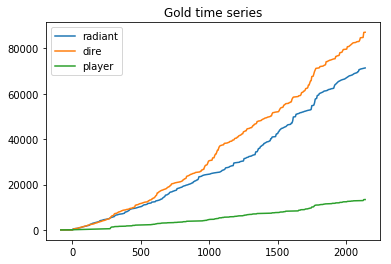

In [ ]:
series = record['series']
plot(series['time'], series['radiant_gold'])
plot(series['time'], series['dire_gold'])
plot(series['time'], series['player_gold'])
title('Gold time series')
_ = legend(['radiant', 'dire', 'player'])

В качестве вспомогательной информации есть описание героев `heroes.csv`, предметов `items.csv` и умений `abilities.csv`.

#### Составы команд

In [18]:
df_abilities = pandas.read_csv(csv_data_path+'/dota2_abilities.csv', index_col='ability_id')
df_abilities.behavior = df_abilities.behavior.apply(
    lambda x: x.split("'")).apply(lambda x: x[1] if len(x) > 1 else 'empty')
df_abilities.head()

,dname,behavior,desc
ability_id,,,
5003,antimage_mana_break,Passive,Burns an opponent's mana on each attack. Mana...
5004,antimage_blink,Point Target,Short distance teleportation that allows Anti-...
5005,antimage_spell_shield,Passive,Increases Anti-Mage's resistance to magic dama...
7314,antimage_counterspell,No Target,Passively grants you magic resistance. Can be ...
5006,antimage_mana_void,Unit Target,For each point of mana missing by the target u...


In [282]:
df_items = pandas.read_csv(csv_data_path+'/dota2_items.csv', index_col='item_id')
df_items.qual = df_items.qual.fillna("empty")


,dname,qual,cost,notes
item_id,,,,
1029,Super Blink Dagger,empty,NaN,NaN
1030,Pocket Tower,empty,NaN,NaN
1032,Pocket Roshan,rare,1000.0,NaN
196,Diffusal Blade,artifact,3850.0,Does not stack with other manabreak abilities.
238,Iron Talon Recipe,empty,125.0,NaN


In [283]:
df_items['qual']

item_id
1         component
2         component
3         component
4         component
5         component
6         component
7         component
8         component
9       secret_shop
10        component
11        component
237      consumable
265       component
244       component
12        component
182       component
247      consumable
13        component
14        component
15        component
16       consumable
17        component
18        component
19        component
20        component
261       component
21        component
22        component
23        component
24      secret_shop
           ...     
229            rare
188      consumable
257      consumable
189           empty
190            rare
230           empty
231            rare
205           empty
206            rare
239          common
207           empty
208            epic
210        artifact
212            rare
214            rare
215           empty
254            rare
1021      component
1022      co

In [246]:
df_heroes = pandas.read_csv(csv_data_path+'/dota2_heroes.csv', index_col='hero_id')

In [247]:
def heros_find_role(role, q):
    if role in q:
        return 1
    else:
        return 0

Герои команды **Radiant**:

In [248]:
df_heroes["hero_Carry"] = [heros_find_role("Carry", df_heroes["roles"][i]) for i in df_heroes.index]
df_heroes["hero_Support"] = [heros_find_role("Support", df_heroes["roles"][i]) for i in df_heroes.index]
df_heroes["hero_Escape"] = [heros_find_role("Escape", df_heroes["roles"][i]) for i in df_heroes.index]
df_heroes["hero_Nuker"] = [heros_find_role("Nuker", df_heroes["roles"][i]) for i in df_heroes.index]
df_heroes["hero_Initiator"] = [heros_find_role("Initiator", df_heroes["roles"][i]) for i in df_heroes.index]
df_heroes["hero_Disabler"] = [heros_find_role("Disabler", df_heroes["roles"][i]) for i in df_heroes.index]
df_heroes["hero_Jungler"] = [heros_find_role("Jungler", df_heroes["roles"][i]) for i in df_heroes.index]
df_heroes["hero_Durable"] = [heros_find_role("Durable", df_heroes["roles"][i]) for i in df_heroes.index]

In [249]:
df_heroes["roles"][23]

"['Carry', 'Support', 'Disabler', 'Initiator', 'Durable', 'Nuker']"

Герои команды **Dire**:

In [250]:
df_heroes

,name,localized_name,roles,agi_gain,attack_range,attack_rate,attack_type,base_agi,base_armor,base_attack_max,...,str_gain,turn_rate,hero_Carry,hero_Support,hero_Escape,hero_Nuker,hero_Initiator,hero_Disabler,hero_Jungler,hero_Durable
hero_id,,,,,,,,,,,,,,,,,,,,,
1,npc_dota_hero_antimage,Anti-Mage,"['Carry', 'Escape', 'Nuker']",3.2,150,1.4,Melee,24,-1.0,33,...,1.3,0.5,1,0,1,1,0,0,0,0
2,npc_dota_hero_axe,Axe,"['Initiator', 'Durable', 'Disabler', 'Jungler']",2.2,150,1.7,Melee,20,-2.0,28,...,3.2,0.6,0,0,0,0,1,1,1,1
3,npc_dota_hero_bane,Bane,"['Support', 'Disabler', 'Nuker', 'Durable']",2.6,400,1.7,Ranged,23,1.0,41,...,2.6,0.6,0,1,0,1,0,1,0,1
4,npc_dota_hero_bloodseeker,Bloodseeker,"['Carry', 'Disabler', 'Jungler', 'Nuker', 'Ini...",3.5,150,1.7,Melee,24,0.0,39,...,2.7,0.5,1,0,0,1,1,1,1,0
5,npc_dota_hero_crystal_maiden,Crystal Maiden,"['Support', 'Disabler', 'Nuker', 'Jungler']",1.6,600,1.7,Ranged,16,0.0,36,...,2.2,0.5,0,1,0,1,0,1,1,0
6,npc_dota_hero_drow_ranger,Drow Ranger,"['Carry', 'Disabler', 'Pusher']",2.5,625,1.7,Ranged,23,-3.0,36,...,1.9,0.7,1,0,0,0,0,1,0,0
7,npc_dota_hero_earthshaker,Earthshaker,"['Support', 'Initiator', 'Disabler', 'Nuker']",1.4,150,1.7,Melee,12,0.0,37,...,3.7,0.9,0,1,0,1,1,1,0,0
8,npc_dota_hero_juggernaut,Juggernaut,"['Carry', 'Pusher', 'Escape']",2.8,150,1.4,Melee,36,0.0,16,...,2.2,0.6,1,0,1,0,0,0,0,0
9,npc_dota_hero_mirana,Mirana,"['Carry', 'Support', 'Escape', 'Nuker', 'Disab...",3.7,630,1.7,Ranged,18,-1.0,30,...,2.2,0.5,1,1,1,1,0,1,0,0


Доля правильных предсказаний существенно выше чем в решении-"заглушке". Сохраним предсказания в CSV-файл, который можно отправлять в систему:

## Решение 3: Дерево решений

Dummy-решение с константным ответом и решение на основе одного признака получились лучше, чем случайное решение, но можно двигаться дальше. Одним из простых алгоритмов машинного обучения дерево решений. Основная идея в разделении объектов выборки на основе простых правил так, чтобы каждой группе сопоставить некоторый ответ.

#### Матрица объект-признак

Исключим из обучающей выборки целевую переменную и два строковых признака.

In [251]:
# X = df_train.drop(columns=['skilled'])
# X_test = df_test
# y = df_train['skilled']

# from sklearn.model_selection import train_test_split

# x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=.1, random_state=1)

#### Построение решающего дерева

Обучением решающее дерево глубины 4. На визуализации можно увидеть, какие правила для разделения выборки были получены.

In [252]:


def params_gen_1(x_in_1):
    x_in = x_in_1.copy()
    x_in["xp_all"] = (x_in["duration"] / 60) * x_in["xp_per_min"]
    
    return x_in

In [253]:
df_train = params_gen_1(df_train)

In [254]:
df_test = params_gen_1(df_test)

In [255]:


def heros_params_gen(x_in_1):
    x_in = x_in_1.copy()
    x_in["hero_attack_type"] = [df_heroes["attack_type"][i] for i in x_in["hero_id"]]
    x_in["hero_attack_range"] = [df_heroes["attack_range"][i] for i in x_in["hero_id"]]
    x_in["hero_base_attack_max"] = [df_heroes["base_attack_max"][i] for i in x_in["hero_id"]]
    x_in["hero_agi_gain"] = [df_heroes["agi_gain"][i] for i in x_in["hero_id"]]
    
    x_in["hero_Carry"] = [df_heroes["hero_Carry"][i] for i in x_in["hero_id"]]
    x_in["hero_Support"] = [df_heroes["hero_Support"][i] for i in x_in["hero_id"]]
    x_in["hero_Escape"] = [df_heroes["hero_Escape"][i] for i in x_in["hero_id"]]
    x_in["hero_Nuker"] = [df_heroes["hero_Nuker"][i] for i in x_in["hero_id"]]
    x_in["hero_Initiator"] = [df_heroes["hero_Initiator"][i] for i in x_in["hero_id"]]
    x_in["hero_Disabler"] = [df_heroes["hero_Disabler"][i] for i in x_in["hero_id"]]
    x_in["hero_Jungler"] = [df_heroes["hero_Jungler"][i] for i in x_in["hero_id"]]
    x_in["hero_Durable"] = [df_heroes["hero_Durable"][i] for i in x_in["hero_id"]]
    return x_in

In [256]:
df_train = heros_params_gen(df_train)

In [257]:
df_test = heros_params_gen(df_test)

In [258]:
def heros_params_gen_2(x_in_1):
    x_in = x_in_1.copy()    
    for c in ['dire', 'rad']:
        for j in range(5):
            x_in[c+'_team_h'+str(j)+"_Carry"] = [df_heroes["hero_Carry"][i] for i in x_in[c+'_team_h'+str(j)]]
            x_in[c+'_team_h'+str(j)+"_Support"] = [df_heroes["hero_Support"][i] for i in x_in[c+'_team_h'+str(j)]]
    return x_in

In [300]:
def str_to_array(st):
    st = st[1:]
    st = st[:-1]
    return  st.split(', ')

In [315]:
def get_param_of_items(param, arr):
    o = []
    for i in arr:
        if (int(i) == 0):
            continue
        o.append(df_items[param][int(i)])
    return o

In [316]:
def count_of(st1, arr):
    i = 0
    for j in arr:
        if j == st1:
            i+=1
    return i

In [319]:
def items_params_gen(x_in_1):
    x_in = x_in_1.copy()    
    x_in["items_secret_shop"] = [count_of('secret_shop', get_param_of_items('qual', str_to_array(j))) for j in x_in["final_items"]]
    x_in["items_consumable"] = [count_of('consumable', get_param_of_items('qual', str_to_array(j))) for j in x_in["final_items"]]
    x_in["items_artifact"] = [count_of('artifact', get_param_of_items('qual', str_to_array(j))) for j in x_in["final_items"]]
    x_in["items_rare"] = [count_of('rare', get_param_of_items('qual', str_to_array(j))) for j in x_in["final_items"]]
    return x_in

In [313]:
def params_gen_2(x_in):
#     x_in = x_in_1.copy()
    for i in x_in.index:
        if x_in.loc[i, 'player_team'] == "dire":
            for j in range(5):
                x_in.loc[i, 'player_team_h'+str(j)] = x_in.loc[i, 'dire_team_h'+str(j)]
                x_in.loc[i, 'an_team_h'+str(j)] = x_in.loc[i, 'rad_team_h'+str(j)]
        else:
            for j in range(5):
                x_in.loc[i, 'player_team_h'+str(j)] = x_in.loc[i, 'rad_team_h'+str(j)]
                x_in.loc[i, 'an_team_h'+str(j)] = x_in.loc[i, 'dire_team_h'+str(j)]               
    
    return x_in

In [260]:
df_train = heros_params_gen_2(df_train)

In [261]:
df_test = heros_params_gen_2(df_test)

In [259]:
df_train = params_gen_2(df_train)

NameError: name 'params_gen_2' is not defined

In [ ]:
df_test = params_gen_2(df_test)

In [320]:
df_train = items_params_gen(df_train)

In [321]:
df_test = items_params_gen(df_test)

In [7]:
def params_gen_3(x_in):
#     x_in = x_in_1.copy()
    x_in["kills_diff"] = x_in["best_kills_x16"] - x_in["kills"]
#     x_in["gpm_diff"] = x_in["best_gpm_x16"] - x_in["gold_per_min"]
#     x_in["xpm_diff"] = x_in["best_xpm_x16"] - x_in["xp_per_min"]
    x_in["assists_diff"] = x_in["best_assists_x16"] - x_in["assists"]
    
#     x_in["kills_diff_2"] = x_in["avg_kills_x16"] - x_in["kills"]
    x_in["gpm_diff_2"] = x_in["avg_gpm_x16"] - x_in["gold_per_min"]
    x_in["xpm_diff_2"] = x_in["avg_xpm_x16"] - x_in["xp_per_min"]
#     x_in["assists_diff_2"] = x_in["avg_assists_x16"] - x_in["assists"]
    return x_in

In [8]:
df_train = params_gen_3(df_train)
df_test = params_gen_3(df_test)

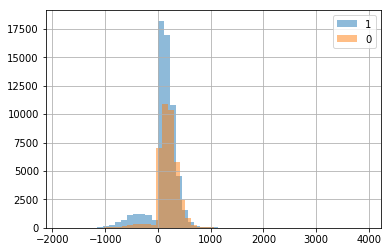

In [6]:
df_train.groupby('skilled')['gpm_diff'].hist(alpha=0.5, bins=50)
plt.legend(df_train['skilled'].unique())
plt.show()

In [29]:
import seaborn as sns

In [41]:
df_train_or_8 = df_train.copy()
df_test_or_8 = df_test.copy()

In [53]:
df_train = df_train_or_8.copy()
df_test = df_test_or_8.copy()

C:\Users\ws_robot\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


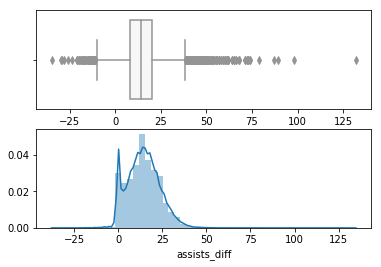

In [230]:
f, axes = plt.subplots(2, 1)
sns.boxplot(df_train["assists_diff"], palette="PRGn", ax=axes[0])
sns.distplot(df_train["assists_diff"], ax=axes[1])

In [107]:
def proc_1(x_in):
    x_in["gold"] = [i if i <= 8500 else 8500 for i in x_in["gold"]]
    x_in["duration"] = [i if i <= 4500 else 4500 for i in x_in["duration"]]
    x_in["avg_xpm_x16"] = [i if i <= 800 else 800 for i in x_in["avg_xpm_x16"]]
    x_in["avg_xpm_x16"] = [i if i >= 150 else 150 for i in x_in["avg_xpm_x16"]]
    x_in["avg_gpm_x16"] = [i if i <= 800 else 800 for i in x_in["avg_xpm_x16"]]
    x_in["avg_gpm_x16"] = [i if i >= 200 else 200 for i in x_in["avg_xpm_x16"]]
    x_in["avg_assists_x16"] = [i if i <= 25 else 25 for i in x_in["avg_assists_x16"]]
    x_in["gold_spent"] = [i if i <= 45000 else 45000 for i in x_in["gold_spent"]]
    x_in["gold_spent"] = [i if i <= 45000 else 45000 for i in x_in["gold_spent"]]
    return x_in

In [108]:
df_train = proc_1(df_train)

In [109]:
df_test = proc_1(df_test)

In [70]:

# df_train["avg_xpm_x16"] = [i if i >= 150 else 150 for i in df_train["avg_xpm_x16"]]

In [75]:

# df_train["avg_xpm_x16"] = [i if i >= 150 else 150 for i in df_train["avg_xpm_x16"]]

In [34]:
columns_with_single_value = [col for col in df_train.columns if df_train[col].unique().shape[0] == 1]

In [35]:
columns_with_single_value

[]

In [62]:
df_train = df_train.drop(['hero_Disabler', 'upgrade_behavior Instant Cast', 'tower_kills',
       'hero_Durable', 'hero_Nuker', 'level', 'upgrade_behavior empty',
       'hero_attack_type', 'dire_barracks_status', 'first_blood_claimed', 'leaver_status',
       'upgrade_behavior Channeled', 'upgrade_behavior Hidden'], axis=1)

KeyError: "['hero_Disabler' 'upgrade_behavior Instant Cast' 'tower_kills'\n 'hero_Durable' 'hero_Nuker' 'level' 'upgrade_behavior empty'\n 'hero_attack_type' 'dire_barracks_status' 'player_team' 'winner_team'\n 'first_blood_claimed' 'leaver_status' 'upgrade_behavior Channeled'\n 'upgrade_behavior Hidden'] not found in axis"

In [63]:
df_test = df_test.drop(['hero_Disabler', 'upgrade_behavior Instant Cast', 'tower_kills',
       'hero_Durable', 'hero_Nuker', 'level', 'upgrade_behavior empty',
       'hero_attack_type', 'dire_barracks_status', 'player_team',
       'winner_team', 'first_blood_claimed', 'leaver_status',
       'upgrade_behavior Channeled', 'upgrade_behavior Hidden'], axis=1)

In [262]:

df_train = df_train.drop(['final_items', 'pre_game_duration'], axis=1)
df_test = df_test.drop(['final_items', 'pre_game_duration'], axis=1)

KeyError: "['final_items'] not found in axis"

In [11]:
to_drop = ["gpm_diff", "xpm_diff", "kills_diff_2"]

In [ ]:
to_drop = ["dire_team_h0_Support", "dire_team_h1_Support", "dire_team_h2_Support", "dire_team_h3_Support", "dire_team_h4_Support", 
          "rad_team_h0_Support", "rad_team_h1_Support", "rad_team_h2_Support", "rad_team_h3_Support", "rad_team_h4_Support"]

In [282]:
to_drop = ['items_artifact', 'rad_team_h4_Carry', 'hero_Initiator',
       'camps_stacked', 'upgrade_behavior AOE', 'roshan_kills', 'hero_Nuker',
       'dire_team_h2_Support', 'items_consumable', 'dire_team_h4_Support',
       'hero_Disabler', 'dire_team_h0_Support', 'rad_team_h2_Support',
       'pre_game_duration', 'rad_team_h0_Support', 'hero_Durable',
       'rad_team_h4_Support', 'rad_team_h1_Support', 'rad_team_h3_Support',
       'hero_Jungler', 'dire_team_h3_Support', 'hero_Escape',
       'dire_team_h1_Support', 'items_secret_shop', 'hero_attack_type']

In [12]:

df_train = df_train.drop(to_drop, axis=1)
df_test = df_test.drop(to_drop, axis=1)

In [146]:
df_train = df_train.drop(['upgrade_behavior AOE', 'pre_game_duration',
       'dire_team_h4_Support', 'roshan_kills', 'dire_team_h0_Support',
       'hero_Jungler', 'items_consumable', 'rad_team_h0_Support',
       'rad_team_h4_Support', 'hero_Escape', 'dire_team_h2_Support',
       'rad_team_h1_Support', 'dire_team_h1_Support', 'rad_team_h2_Support',
       'dire_team_h3_Support', 'rad_team_h3_Support', 'items_secret_shop',
       'player_team', 'winner_team'], axis=1)

In [147]:
df_test = df_test.drop(['upgrade_behavior AOE', 'pre_game_duration',
       'dire_team_h4_Support', 'roshan_kills', 'dire_team_h0_Support',
       'hero_Jungler', 'items_consumable', 'rad_team_h0_Support',
       'rad_team_h4_Support', 'hero_Escape', 'dire_team_h2_Support',
       'rad_team_h1_Support', 'dire_team_h1_Support', 'rad_team_h2_Support',
       'dire_team_h3_Support', 'rad_team_h3_Support', 'items_secret_shop',
       'player_team', 'winner_team'], axis=1)

In [13]:
import time
import os

current_timestamp = int(time.time())
submission_path = save_path+'/pre_process_csv_json/train_all_{}.csv'.format("9_3_all")
# submission_path = 'submissions/{}_{}.csv'.format(current_timestamp, str(clf_to_test.get_param('max_depth')) + '_' + str(clf_to_test.get_param('iterations'))+ '_' + str(clf_to_test.get_param('learning_rate') ) )

if not os.path.exists(save_path+'/pre_process_csv_json'):
    os.makedirs(save_path+'/pre_process_csv_json')

print(submission_path)
df_train.to_csv(submission_path, index=True)

current_timestamp = int(time.time())
submission_path = save_path+'/pre_process_csv_json/test_all_{}.csv'.format("9_3_all")
# submission_path = 'submissions/{}_{}.csv'.format(current_timestamp, str(clf_to_test.get_param('max_depth')) + '_' + str(clf_to_test.get_param('iterations'))+ '_' + str(clf_to_test.get_param('learning_rate') ) )

if not os.path.exists(save_path+'/pre_process_csv_json'):
    os.makedirs(save_path+'/pre_process_csv_json')

print(submission_path)
df_test.to_csv(submission_path, index=True)

sber_data/pre_process_csv_json/train_all_9_3_all.csv
sber_data/pre_process_csv_json/test_all_9_3_all.csv


In [22]:
df_train = pandas.read_csv(save_path+'/pre_process_csv_json/train_all_9_1.csv', index_col='id')
df_test = pandas.read_csv(save_path+'/pre_process_csv_json/test_all_9_1.csv', index_col='id')

In [213]:
# df_train = df_train.drop(["player_team", "winner_team"], axis=1)
# df_test = df_test.drop(["player_team", "winner_team"], axis=1)

In [23]:
df_train.columns

Index(['skilled', 'duration', 'pre_game_duration', 'first_blood_time',
       'hero_id', 'hero_pick_order', 'party_players', 'kills', 'deaths',
       'assists',
       ...
       'items_secret_shop', 'items_consumable', 'items_artifact', 'items_rare',
       'kills_diff', 'gpm_diff', 'xpm_diff', 'kills_diff_2', 'gpm_diff_2',
       'xpm_diff_2'],
      dtype='object', length=103)

In [25]:
from sklearn.metrics import accuracy_score
X = df_train.drop(columns=['skilled'])
X_test = df_test
y = df_train['skilled']

from sklearn.model_selection import train_test_split

x_train, x_validation, y_train, y_validation = train_test_split(X, y, test_size=0.02, random_state=32)

In [26]:
string_fit = ["hero_attack_type", "player_team", "winner_team"]
cat_fit = []
for f in string_fit:
    for i in range(len(x_train.columns)):
        if f == x_train.columns[i]:
            cat_fit.append(i)

In [27]:
cat_fit

[]

In [28]:
eval_set = (x_validation, y_validation)

In [29]:
#!pip install catboost

In [337]:
from catboost import CatBoostClassifier
clfC = CatBoostClassifier(iterations=3000, max_depth=7) #iterations=1000, learning_rate=0.03, max_depth=6

In [338]:
eval_set = (x_validation, y_validation)
clfC.fit(x_train, y_train, eval_set=eval_set, cat_features=cat_fit)

Learning rate set to 0.177703
0:	learn: 0.6668161	test: 0.6674135	best: 0.6674135 (0)	total: 136ms	remaining: 1m 1s
1:	learn: 0.6459804	test: 0.6471046	best: 0.6471046 (1)	total: 244ms	remaining: 54.6s
2:	learn: 0.6323384	test: 0.6349716	best: 0.6349716 (2)	total: 359ms	remaining: 53.4s
3:	learn: 0.6215582	test: 0.6246210	best: 0.6246210 (3)	total: 465ms	remaining: 51.9s
4:	learn: 0.6125979	test: 0.6159795	best: 0.6159795 (4)	total: 570ms	remaining: 50.7s
5:	learn: 0.6055333	test: 0.6097868	best: 0.6097868 (5)	total: 676ms	remaining: 50.1s
6:	learn: 0.5999983	test: 0.6053699	best: 0.6053699 (6)	total: 780ms	remaining: 49.4s
7:	learn: 0.5957617	test: 0.6019702	best: 0.6019702 (7)	total: 887ms	remaining: 49s
8:	learn: 0.5920304	test: 0.5975105	best: 0.5975105 (8)	total: 990ms	remaining: 48.5s
9:	learn: 0.5876972	test: 0.5940676	best: 0.5940676 (9)	total: 1.1s	remaining: 48.4s
10:	learn: 0.5843683	test: 0.5904790	best: 0.5904790 (10)	total: 1.2s	remaining: 47.8s
11:	learn: 0.5815334	test:

In [34]:
from xgboost import XGBClassifier
xclf = XGBClassifier(max_depth=8, n_jobs=8, n_estimators=800)

In [35]:
xclf.fit(x_train, y_train, eval_set=[eval_set])

[0]	validation_0-error:0.29029
[1]	validation_0-error:0.294795
[2]	validation_0-error:0.291792
[3]	validation_0-error:0.284284
[4]	validation_0-error:0.282282
[5]	validation_0-error:0.281782
[6]	validation_0-error:0.27978
[7]	validation_0-error:0.27978
[8]	validation_0-error:0.275776
[9]	validation_0-error:0.280781
[10]	validation_0-error:0.28028
[11]	validation_0-error:0.274775
[12]	validation_0-error:0.276276
[13]	validation_0-error:0.271772
[14]	validation_0-error:0.271772
[15]	validation_0-error:0.269269
[16]	validation_0-error:0.273273
[17]	validation_0-error:0.274775
[18]	validation_0-error:0.27027
[19]	validation_0-error:0.26977
[20]	validation_0-error:0.270771
[21]	validation_0-error:0.271271
[22]	validation_0-error:0.267768
[23]	validation_0-error:0.265265
[24]	validation_0-error:0.263263
[25]	validation_0-error:0.266767
[26]	validation_0-error:0.265265
[27]	validation_0-error:0.267267
[28]	validation_0-error:0.264765
[29]	validation_0-error:0.262763
[30]	validation_0-error:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=800,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [ ]:
clfC.get_param('max_depth')

7

In [ ]:

# import xgboost
# import py3 as PY3
# PY3 = py3
from catboost import CatBoostRegressor

# clfR = CatBoostRegressor(iterations=1000, learning_rate=0.03, max_depth=6)
clfR = CatBoostRegressor(iterations=3400, max_depth=7)
eval_set = (x_validation, y_validation)
clfR.fit(x_train, y_train, eval_set=eval_set, cat_features=cat_fit)

0:	learn: 0.6225981	test: 0.6238754	best: 0.6238754 (0)	total: 67.8ms	remaining: 1m 7s
1:	learn: 0.6146478	test: 0.6159177	best: 0.6159177 (1)	total: 148ms	remaining: 1m 13s
2:	learn: 0.6069569	test: 0.6082031	best: 0.6082031 (2)	total: 220ms	remaining: 1m 13s
3:	learn: 0.5996565	test: 0.6008855	best: 0.6008855 (3)	total: 293ms	remaining: 1m 12s
4:	learn: 0.5926814	test: 0.5939594	best: 0.5939594 (4)	total: 373ms	remaining: 1m 14s
5:	learn: 0.5860162	test: 0.5873205	best: 0.5873205 (5)	total: 445ms	remaining: 1m 13s
6:	learn: 0.5795465	test: 0.5808452	best: 0.5808452 (6)	total: 511ms	remaining: 1m 12s
7:	learn: 0.5734013	test: 0.5747095	best: 0.5747095 (7)	total: 592ms	remaining: 1m 13s
8:	learn: 0.5675918	test: 0.5689076	best: 0.5689076 (8)	total: 660ms	remaining: 1m 12s
9:	learn: 0.5621634	test: 0.5634468	best: 0.5634468 (9)	total: 725ms	remaining: 1m 11s
10:	learn: 0.5567951	test: 0.5580991	best: 0.5580991 (10)	total: 807ms	remaining: 1m 12s
11:	learn: 0.5516760	test: 0.5529732	best

In [32]:
## from sklearn.metrics import accuracy_score
clf_to_test = xclf

print('Train accuracy:', accuracy_score(y_train, np.round(clf_to_test.predict(x_train))))
print('Vall accuracy:', accuracy_score(y_validation, np.round(clf_to_test.predict(x_validation))))

Train accuracy: 0.9858796603762018
Vall accuracy: 0.7957957957957958


In [33]:
np.round(clf_to_test.predict(x_train))

array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

Catboost Class, standart
Train accuracy: 0.8298955489739347
Vall accuracy: 0.7665198237885462

Catboost Class, 1200
Train accuracy: 0.8366516647870401
Vall accuracy: 0.7651181417701242

1500
Train accuracy: 0.8438715389398906
Vall accuracy: 0.7647176611934321

1650
Train accuracy: 0.8773464590996765
Vall accuracy: 0.7641169403283941

1900
Train accuracy: 0.9211505422810586
Vall accuracy: 0.7913496195434522
test 


Train accuracy: 0.9211505422810586
Vall accuracy: 0.7913496195434522

2300
Train accuracy: 0.931479705302655
Vall accuracy: 0.7875450540648778

Train accuracy: 0.9311845863591809
Vall accuracy: 0.7927513015618742

2300 md 8

Train accuracy: 0.9760215858427227
Vall accuracy: 0.7797356828193832

#### Предсказания на тестовой выборке

Сделаем предсказание деревом решений на тестовой выборке и сохраним предсказания в файл.

In [325]:
def displayImp(in_clf, x_in):
    if hasattr(in_clf, 'coef_'):
        df_importances = sorted(list(zip(x_in.columns, in_clf.coef_.ravel())), key=lambda tpl: tpl[1], reverse=True)
    else:
        df_importances= sorted(list(zip(x_in.columns, in_clf.feature_importances_.ravel())), key=lambda tpl: tpl[1], reverse=True)
    df_importances = pd.DataFrame(df_importances, columns=['feature', 'importance'])
    df_importances = df_importances.set_index('feature')
    df_importances = df_importances
    df_importances.plot(kind='bar', figsize=(15, 3))
    plt.show()
    display(df_importances)
    return df_importances

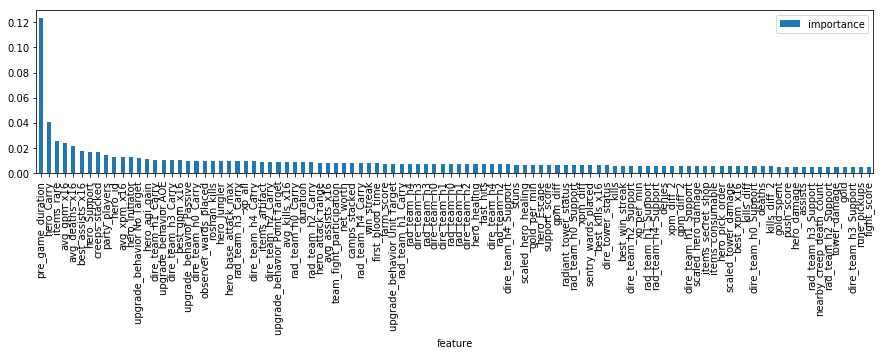

,importance
feature,
pre_game_duration,0.123441
hero_Carry,0.040850
items_rare,0.025436
avg_gpm_x16,0.023879
avg_deaths_x16,0.021823
best_assists_x16,0.017719
hero_Support,0.017087
creeps_stacked,0.016878
party_players,0.014859


In [354]:
df_importances = displayImp(clf_to_test, x_train)

In [281]:
df_importances.tail(25).index

Index(['items_artifact', 'rad_team_h4_Carry', 'hero_Initiator',
       'camps_stacked', 'upgrade_behavior AOE', 'roshan_kills', 'hero_Nuker',
       'dire_team_h2_Support', 'items_consumable', 'dire_team_h4_Support',
       'hero_Disabler', 'dire_team_h0_Support', 'rad_team_h2_Support',
       'pre_game_duration', 'rad_team_h0_Support', 'hero_Durable',
       'rad_team_h4_Support', 'rad_team_h1_Support', 'rad_team_h3_Support',
       'hero_Jungler', 'dire_team_h3_Support', 'hero_Escape',
       'dire_team_h1_Support', 'items_secret_shop', 'hero_attack_type'],
      dtype='object', name='feature')

In [327]:
y_pred = clf_to_test.predict(X_test)
y_submission = pandas.DataFrame({'skilled': y_pred}, index=df_test.index)

import time
import os

current_timestamp = int(time.time())
submission_path = save_path+'/submissions/{}_{}.csv'.format(current_timestamp, str(clf_to_test.get_param('max_depth')) + '_' + str(clf_to_test.get_param('iterations'))+ '_' + str(clf_to_test.get_param('learning_rate') ) )
# submission_path = 'submissions/{}_{}.csv'.format(current_timestamp, str(clf_to_test.get_param('max_depth')) + '_' + str(clf_to_test.get_param('iterations'))+ '_' + str(clf_to_test.get_param('learning_rate') ) )

if not os.path.exists(save_path+'/submissions'):
    os.makedirs(save_path+'/submissions')

print(submission_path)
y_submission.to_csv(submission_path, index=True)

AttributeError: 'XGBClassifier' object has no attribute 'get_param'

In [355]:
y_pred = clf_to_test.predict(X_test)
y_submission = pandas.DataFrame({'skilled': y_pred}, index=df_test.index)

import time
import os

current_timestamp = int(time.time())
# submission_path = save_path+'/submissions/{}_{}.csv'.format(current_timestamp, str(clf_to_test.get_param('max_depth')) + '_' + str(clf_to_test.get_param('iterations'))+ '_' + str(clf_to_test.get_param('learning_rate') ) )
submission_path = 'submissions/{}_{}.csv'.format(current_timestamp, "xgb_8_450_9_2_all")

if not os.path.exists('submissions'):
    os.makedirs('submissions')

print(submission_path)
y_submission.to_csv(submission_path, index=True)

submissions/1552805845_xgb_9_450.csv


#### Оценка качества на обучающей выборке

Train accuracy: 0.659701014308458


#### Оценка качества методом кросс-валидации

Оценка качества модели на обучающей выборке некорректна, так как мы оцениваем качество алгоритма, который видел правильные ответы (и мог их запомнить). Для избежения этого используют кросс-валидацию, то есть оценивают качество алгоритма на частях обучающей выборки, которую не видел алгоритм при обучении.

In [ ]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(
    DecisionTreeClassifier(max_depth=4),
    X, y,
    cv=5,
    n_jobs=-1,
)

print('Validation accuracy:', accuracy_score(df_train['skilled'], y_pred))

Validation accuracy: 0.6575282113926966


## Идеи по дальнейшему улучшению точности решения

### Подбор параметров модели

Для получения более высокого качества часто необходимо подобрать значения параметров алгоритма. Например, у решающего дерева есть параметр глубина дерева `max_depth`. Увеличим значение с 4 до 8. 

In [ ]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(
    DecisionTreeClassifier(max_depth=8),
    X, y,
    cv=5,
    n_jobs=-1,
)

print('Validation accuracy:', accuracy_score(df_train['skilled'], y_pred))

Validation accuracy: 0.6730181934695757


Качество алгоритма выросло!

### Использование различных алгоритмов машинного обучения

Решающие деревья — один из методов машинного обучения, есть много других алгоритмов, которые при правильном использовании могут дать лучший результат. Воспользуемся, например, случайным лесом — множеством решающих деревьев, ответы которых усредняются.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

y_pred = cross_val_predict(
    RandomForestClassifier(n_estimators=100),
    X, y,
    cv=5,
    n_jobs=-1,
)

print('Validation accuracy:', accuracy_score(df_train['skilled'], y_pred))

Validation accuracy: 0.7168447297013147


### Использование категориальных признаков

В нашей выборке есть числовые признаки, которые по смыслу означают категории. Например, герой, за которого играл человек. Посмотрим на различия в `avg_gpm_x16` у двух типов героев. 

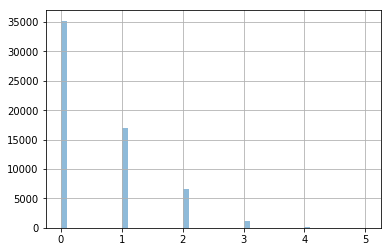

In [326]:

df_train.loc[(df_train.skilled == 0 , 'items_artifact'].hist(bins=50, alpha=0.5)

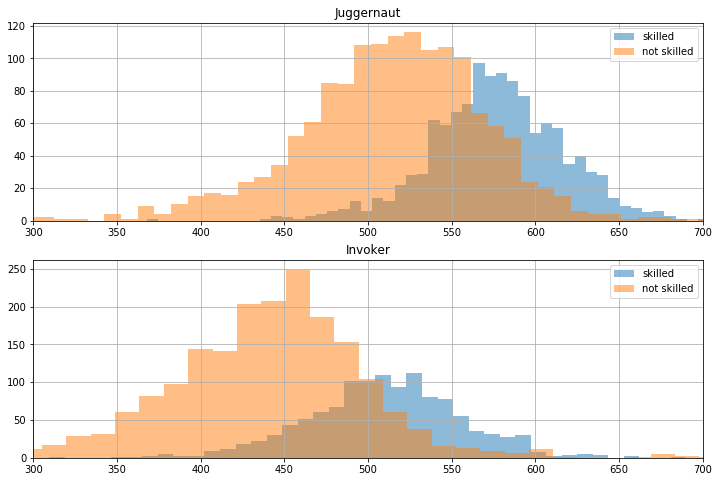

In [ ]:
selected_heroes = [(8, 'Juggernaut'), (74, 'Invoker')]

figure(figsize=(12, 8))
for i, (selected_hero, hero_name) in enumerate(selected_heroes):
    subplot(len(selected_heroes), 1, i+1)
    df_train.loc[(df_train.skilled == 1) & (df_train.hero_id == selected_hero), selected_column].hist(bins=50, alpha=0.5)
    df_train.loc[(df_train.skilled == 0) & (df_train.hero_id == selected_hero), selected_column].hist(bins=50, alpha=0.5)
    xlim([300, 700])
    legend(['skilled', 'not skilled'])
    title(hero_name)

Большинство алгоритмов машинного обучения не понимает, что признак по смыслу категориальный, а считает его числом. Поэтому попробуем добавить признаки `играл за героя X` для всех возможных героев.

In [ ]:
for hero_id in set(df_train.hero_id):
    df_train['is_hero_{}'.format(hero_id)] = df_train.hero_id == hero_id
    df_test['is_hero_{}'.format(hero_id)] = df_test.hero_id == hero_id

X = df_train.drop(columns=['skilled', 'player_team', 'winner_team'])
X_test = df_test.drop(columns=['player_team', 'winner_team'])
y = df_train['skilled']

y_pred = cross_val_predict(
    RandomForestClassifier(n_estimators=100),
    X, y,
    cv=5,
    n_jobs=-1,
)

print('Validation accuracy:', accuracy_score(df_train['skilled'], y_pred))

Validation accuracy: 0.7161338126182776


### Использование расширенного набора данных, создание новых признаков

Как уже говорилось, есть дополнительная информация о героях, умениях и предметах. Можно сгенерировать новые признаки на их основе. 

Посчитаем, каких типов умения применялись игроков и в каком количестве. Для этого нужно воспользовать большой версией данных (это займёт некоторое время).

,dname,behavior,desc
ability_id,,,
5003,antimage_mana_break,Passive,Burns an opponent's mana on each attack. Mana...
5004,antimage_blink,Point Target,Short distance teleportation that allows Anti-...
5005,antimage_spell_shield,Passive,Increases Anti-Mage's resistance to magic dama...
7314,antimage_counterspell,No Target,Passively grants you magic resistance. Can be ...
5006,antimage_mana_void,Unit Target,For each point of mana missing by the target u...


In [14]:
import tqdm
import json
for ability_behavior in set(df_abilities.behavior.fillna('empty')):
    df_train['upgrade_behavior {}'.format(ability_behavior)] = 0
    df_test['upgrade_behavior {}'.format(ability_behavior)] = 0
    
with open(json_data_path+'/dota2_skill_train.jsonlines') as fin:
#     qwqw = 0
#     print("total ", len(fin))
    for line in fin:
        qwqw+=1
        record = json.loads(line)
        for ability_upgrade in record['ability_upgrades']:
            df_train.loc[record['id'], 'upgrade_behavior {}'.format(
                df_abilities.loc[ability_upgrade, 'behavior'])] += 1
#         print(qwqw)
import time
import os

current_timestamp = int(time.time())
submission_path = save_path+'/pre_process_csv_json/train_{}.csv'.format(current_timestamp)
# submission_path = 'submissions/{}_{}.csv'.format(current_timestamp, str(clf_to_test.get_param('max_depth')) + '_' + str(clf_to_test.get_param('iterations'))+ '_' + str(clf_to_test.get_param('learning_rate') ) )

if not os.path.exists(save_path+'/pre_process_csv_json'):
    os.makedirs(save_path+'/pre_process_csv_json')

print(submission_path)
df_train.to_csv(submission_path, index=True)

            
with open(json_data_path+'/dota2_skill_test.jsonlines') as fin:
    for line in fin:
        record = json.loads(line)
        for ability_upgrade in record['ability_upgrades']:
            df_test.loc[record['id'], 'upgrade_behavior {}'.format(
                df_abilities.loc[ability_upgrade, 'behavior'])] += 1
            


current_timestamp = int(time.time())
submission_path = save_path+'/pre_process_csv_json/test_{}.csv'.format(current_timestamp)
# submission_path = 'submissions/{}_{}.csv'.format(current_timestamp, str(clf_to_test.get_param('max_depth')) + '_' + str(clf_to_test.get_param('iterations'))+ '_' + str(clf_to_test.get_param('learning_rate') ) )

if not os.path.exists(save_path+'/pre_process_csv_json'):
    os.makedirs(save_path+'/pre_process_csv_json')

print(submission_path)
df_test.to_csv(submission_path, index=True)


sber_data/pre_process_csv_json/train_1552737351.csv
sber_data/pre_process_csv_json/test_1552737730.csv


In [ ]:
X = df_train.drop(columns=['skilled', 'player_team', 'winner_team'])
X_test = df_test.drop(columns=['player_team', 'winner_team'])
y = df_train['skilled']

y_pred = cross_val_predict(
    RandomForestClassifier(n_estimators=100),
    X, y,
    cv=5,
    n_jobs=-1,
)

print('Validation accuracy:', accuracy_score(df_train['skilled'], y_pred))

Validation accuracy: 0.7206296121997376


### Ансамблирование моделей

Один алгоритм хорошо, а несколько могут решить задачу лучше (там, где один не уверен, другой может дать правильный ответ). Возьмём к случайному лесу градиентный бустинг (ещё один алгоритм на основе решающих деревьев), предскажем с помощью них степень уверенности в `1` (вероятность того, что игрок `skilled`). Усредним их и переведём в предсказание классов.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
X = df_train.drop(columns=['skilled', 'player_team', 'winner_team'])
X_test = df_test.drop(columns=['player_team', 'winner_team'])
y = df_train['skilled']

y_pred_rf = cross_val_predict(
    RandomForestClassifier(n_estimators=100),
    X, y,
    cv=5,
    n_jobs=-1,
    method='predict_proba'
)[:, 1]

y_pred_gb = cross_val_predict(
    GradientBoostingClassifier(),
    X, y,
    cv=5,
    n_jobs=-1,
    method='predict_proba'
)[:, 1]

y_pred = 0.5 * y_pred_rf + 0.5 * y_pred_gb

print('Validation accuracy RF:', accuracy_score(df_train['skilled'], y_pred_rf > 0.5))
print('Validation accuracy GB:', accuracy_score(df_train['skilled'], y_pred_gb > 0.5))
print('Validation accuracy RF+GB:', accuracy_score(df_train['skilled'], y_pred > 0.5))

Validation accuracy RF: 0.7197084238667881
Validation accuracy GB: 0.7159135284517028
Validation accuracy RF+GB: 0.722902544282124


Сохраним таблицу с предсказаниями.

In [ ]:
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X, y)
y_pred_rf = model_rf.predict_proba(X_test)[:, 1]

model_gb = GradientBoostingClassifier()
model_gb.fit(X, y)
y_pred_gb = model_gb.predict_proba(X_test)[:, 1]

y_pred = ((0.5 * y_pred_rf + 0.5 * y_pred_gb) > 0.5).astype(int)
df_submission = pandas.DataFrame({'skilled': y_pred}, index=df_test.index)
df_submission.to_csv('submission_ensemble.csv')
df_submission.tail()

,skilled
id,
193392,0
193393,0
193402,0
193410,0
193411,0


### Использовать опыт решения других соревнований

[YouTube: Тренировки по машинному обучению](https://www.youtube.com/channel/UCeq6ZIlvC9SVsfhfKnSvM9w)

[Материалы Академии Искусственного Интеллекта 2018](http://contest.ai-academy.ru/description)

[YouTube: Александр Мамаев — Предсказание победы команды в матче Dota2](https://www.youtube.com/watch?v=YSQqHlQwQDY&t=50s)